# Figure 3: Laplacian of LERW physical networks

In [1]:
import sys
sys.path.append('../simulations/')
import RWModelsCPP as rw

import numpy as np
import igraph as ig
import itertools

from statsmodels.distributions.empirical_distribution import ECDF

import matplotlib.pyplot as plt
import matplotlib

from scipy.linalg import eigh

Color scheme and fonts

In [22]:
colors = [
    "#3658BF",
    "#03A678",
    "#F2B705",
    "#F24141",
    "#F28705"
]

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'CMMI10'
plt.rcParams['mathtext.rm'] = 'CMR10'
plt.rcParams['mathtext.cal'] = 'CMSY10'

plt.rcParams.update({'font.size': 20})


Some useful functions.

In [2]:
def PartLoadRWNet(filename, prefix='../data/simulations/'):
    with open(prefix+filename+".csv","rt") as f:
        next(f)
        walk_length = []
        new_sites_visited = []
        el = []
        for line in f:
            row = [int(x) for x in line.split(',')]
            if row[1]>-1:
                el.append((row[0],row[1]))
            walk_length.append(row[2])
            new_sites_visited.append(row[3])
            
    return el, walk_length, new_sites_visited

In [3]:
def GetSkeleton(el, walks, L, D):
    '''
    Constructs the full network-of-networks, i.e., where each node is a substrate 
    site that is occupied by the physical network.
    
    Edges are labeled  to indicate whether they are connecting two sites inside a physical node
    or they bind together two different physical nodes.
    
    returns an igraph Graph
    '''
    
    
    sk = ig.Graph(n=L**D)
    
    #each lattice site is a vertex in the skeleton
    sk.vs['coord'] = [DeflattenCoordinate(idx,L, D) for idx in range(L**D)]
    
    #skeleton vertices are labeled by the physical nodes occupying them
    for idx in walks[:1]:
        sk.vs['node']=0
    for e,walk in zip(el,walks[1:]):
        node = e[0]
        #only the first physical node traversing the site matters
        for idx in walk[:-1]:
            sk.vs[idx]['node']=node
            
    #two sites are connected if they appear as consecutive sites in a random walk
    sk_el = set()
    for walk in walks:
        for idx1, idx2 in zip(walk[:-1],walk[1:]):
            if idx1<idx2:
                sk_el.add((idx1,idx2))
            else:
                sk_el.add((idx2,idx1))
    
    sk.add_edges(sk_el)
    
    sk.es['connection'] = [True if sk.vs[e.source]['node']!=sk.vs[e.target]['node'] else False for e in sk.es]
    
    sk['L']=L
    sk['D']=D
    
    return sk

def GetCombGraph(el,N=None):
    '''
    Constructs the combinatorial network from an edge list
    '''
    if N is None:
        cg = ig.Graph(n=el[-1][0]+1)
    else:
        cg = ig.Graph(n=N)
    cg.add_edges(el)
    
    return cg

def DeflattenCoordinate(flat,L,D):
    coord = []
    for k in range(D):
        c = (flat//L**k)%L
        coord.append(c)
    return coord

### All $\lambda$s vs $w$

Generate a physical network

In [4]:
D=2
L=10

grid = ig.Graph.Lattice(D*[L], circular=True)
el,walks = rw.Full("LERW",grid.get_adjlist(),L)

Get the skeleton representing the full physical layout and the combinatorial network as an igraph Graph

In [5]:
sk0 = GetSkeleton(el, walks, L, D)
cg0 = GetCombGraph(el)

Calculate eigenvalues for variuous `w` link weights

In [6]:
all_eigs= []

ws = np.logspace(-4,0,49)
for i,w in enumerate(ws):
    sk0.es['weight']=[w if e['connection'] else 1. for e in sk0.es]
    
    Lap = sk0.laplacian(weights='weight',normalized=False)

    eigs, vecs = eigh(Lap)

    all_eigs.append(eigs)

In [7]:
a_all_eigs = np.array(all_eigs).T
a_all_eigs = a_all_eigs[np.argsort(a_all_eigs[:,0])]

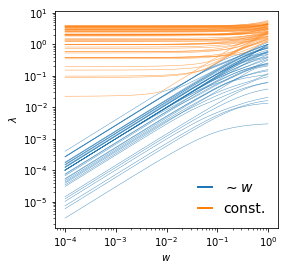

In [8]:
fig=plt.figure(figsize=(4,4))

for i in range(1,cg0.vcount()):
    plt.plot(ws,a_all_eigs[i],c=colors[0],lw=.5,alpha=.75)
for i in range(cg0.vcount(),sk0.vcount()-1):
    plt.plot(ws,a_all_eigs[i],c=colors[1],lw=.5,alpha=.75)

plt.plot([None],[None],c=colors[0],lw=2.,label=r'$\sim w$')
plt.plot([None],[None],c=colors[1],lw=2.,label=r'const.')
plt.xscale('log')
plt.yscale('log')

plt.ylabel(r'$\lambda$')
plt.xlabel(r'$w$')
plt.legend(handlelength=1.,fontsize=14,frameon=False)


### Randomized distribution

Generate a physical network

In [9]:
D=2
L=100
grid = ig.Graph.Lattice(D*[L], circular=True)

el,walks = rw.Full("LERW",grid.get_adjlist(),L)

In [10]:
sk = GetSkeleton(el, walks, L, D)
cg = GetCombGraph(el)

Get node volumes by counting the sites occupied by each physical node

In [11]:
_,vs = np.unique(sk.vs['node'],return_counts=True)
vs=np.diag(vs**(-.5))

Calculate the physical Laplacian spectrum

In [12]:
cg.es['weights']=1.
scg = cg.copy().simplify(combine_edges=sum)
Lap = scg.laplacian(weights='weights',normalized=False)
eigs_pcg, vecs_pcg = eigh(np.dot(vs,np.dot(Lap,vs)))

Calculate the combinatorial Laplacian spectrum

In [13]:
cg.es['weights']=1.
scg = cg.copy().simplify(combine_edges=sum)
Lap = scg.laplacian(weights='weights',normalized=False)
eigs_cg, vecs_cg = eigh(Lap)

Shuffle node volumes and calculate the randomized physical Laplacian

In [14]:
_,r_vs = np.unique(sk.vs['node'],return_counts=True)
np.random.shuffle(r_vs)
r_vs=np.diag(r_vs**(-.5))

cg.es['weights']=1.
scg = cg.copy().simplify(combine_edges=sum)
Lap = scg.laplacian(weights='weights',normalized=False)
eigs_rpcg, vecs_rpcg = eigh(np.dot(r_vs,np.dot(Lap,r_vs)))

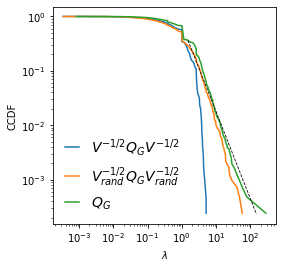

In [15]:
fig=plt.figure(figsize=(4,4))

ecdf = ECDF(eigs_pcg[1:],side='left')
pcg_ccdf = 1-ecdf(eigs_pcg[1:])
plt.plot(eigs_pcg[1:],pcg_ccdf,label=r'$V^{-1/2}Q_{G}V^{-1/2}$')

ecdf = ECDF(eigs_rpcg[1:],side='left')
rpcg_ccdf = 1-ecdf(eigs_rpcg[1:])
plt.plot(eigs_rpcg[1:],rpcg_ccdf,label=r'$V_{rand}^{-1/2}Q_{G}V_{rand}^{-1/2}$')

ecdf = ECDF(eigs_cg[1:],side='left')
cg_ccdf = 1-ecdf(eigs_cg[1:])
plt.plot(eigs_cg[1:],cg_ccdf,label=r'$Q_{G}$')

plt.xscale('log')
plt.yscale('log')

plt.ylabel('CCDF')
plt.xlabel(r'$\lambda$')

zetas = [5/4, 1.6183, 2, 2]
x=np.logspace(np.log10(1.5),np.log10(150.),10,base=10)
plt.plot(x,.7*x**(-2/zetas[0]),'k--',linewidth=.8)


plt.legend(handlelength=1.,fontsize=14,frameon=False);


### N scaling

In [16]:
LDs = np.logspace(2,20,10,base=2,dtype=int)
indep = 10

lambda2 = {}
lambda2['LD'] = {}
lambda2['L'] = {}
lambda2['phys'] = {}
lambda2['phys_std'] = {}
lambda2['nonphys'] = {}
lambda2['nonphys_std'] = {}
lambda2['rand'] = {}
lambda2['rand_std'] = {}

Ds = [2,3,4,5]
wts = ['LERW','LERW','LERW','LERW']
LDss = [LDs[:-4],LDs[:-4],LDs[1:-4],LDs[2:-4]]
for D,walk_type, lds in zip(Ds,wts,LDss):
    key = (D,walk_type)
    print(key)
    for d in lambda2.values():
        d[key]=[]
    for LD in lds:
        print(LD, end=': ')
        L = round(LD**(1/D))
        lambda2['L'][key].append(L)
        lambda2['LD'][key].append(L**D)
        l0=1
        phys_lamb2s = []
        nonphys_lamb2s = []
        rand_lamb2s = []
        for i in range(indep):
            print(i,end=' ')
            
            # load combinatorial networks and node volumes 
            el, _ , vols = PartLoadRWNet(f"RWnet.{walk_type}.L{L}D{D}init{l0}copy{i:02d}")
            vols = np.array(vols)
            
            # calculate the spectra
            cg  = GetCombGraph(el)
            vs  = np.diag(vols**(-.5))
            Lap = cg.laplacian(normalized=False)
            
            eigs = eigh(np.dot(vs,np.dot(Lap,vs)), eigvals_only=True,subset_by_index=[1,1])
            phys_lamb2s.append(eigs[0])
            
            eigs = eigh(Lap, eigvals_only=True,subset_by_index=[1,1])
            nonphys_lamb2s.append(eigs[0])
            
            np.random.shuffle(vols)
            r_vs=np.diag(vols**(-.5))
            eigs = eigh(np.dot(r_vs,np.dot(Lap,r_vs)), eigvals_only=True,subset_by_index=[1,1])
            rand_lamb2s.append(eigs[0])
        
        lambda2['phys'][key].append(np.mean(phys_lamb2s))
        lambda2['phys_std'][key].append(np.std(phys_lamb2s))
        lambda2['nonphys'][key].append(np.mean(nonphys_lamb2s))
        lambda2['nonphys_std'][key].append(np.std(nonphys_lamb2s))
        lambda2['rand'][key].append(np.mean(rand_lamb2s))
        lambda2['rand_std'][key].append(np.std(rand_lamb2s))
    print()


(2, 'LERW')
4: 0 1 2 3 4 5 6 7 8 9 16: 0 1 2 3 4 5 6 7 8 9 64: 0 1 2 3 4 5 6 7 8 9 256: 0 1 2 3 4 5 6 7 8 9 1024: 0 1 2 3 4 5 6 7 8 9 4096: 0 1 2 3 4 5 6 7 8 9 
(3, 'LERW')
4: 0 1 2 3 4 5 6 7 8 9 16: 0 1 2 3 4 5 6 7 8 9 64: 0 1 2 3 4 5 6 7 8 9 256: 0 1 2 3 4 5 6 7 8 9 1024: 0 1 2 3 4 5 6 7 8 9 4096: 0 1 2 3 4 5 6 7 8 9 
(4, 'LERW')
16: 0 1 2 3 4 5 6 7 8 9 64: 0 1 2 3 4 5 6 7 8 9 256: 0 1 2 3 4 5 6 7 8 9 1024: 0 1 2 3 4 5 6 7 8 9 4096: 0 1 2 3 4 5 6 7 8 9 
(5, 'LERW')
64: 0 1 2 3 4 5 6 7 8 9 256: 0 1 2 3 4 5 6 7 8 9 1024: 0 1 2 3 4 5 6 7 8 9 4096: 0 1 2 3 4 5 6 7 8 9 


In [17]:
LDs = np.logspace(2,20,10,base=2,dtype=int)
indep = 10

lambdaN = {}
lambdaN['LD'] = {}
lambdaN['L'] = {}
lambdaN['phys'] = {}
lambdaN['phys_std'] = {}
lambdaN['nonphys'] = {}
lambdaN['nonphys_std'] = {}
lambdaN['rand'] = {}
lambdaN['rand_std'] = {}

Ds = [2,3,4,5]
wts = ['LERW','LERW','LERW','LERW']
LDss = [LDs[:-4],LDs[:-4],LDs[1:-4],LDs[2:-4]]
for D,walk_type, lds in zip(Ds,wts,LDss):
    key = (D,walk_type)
    print(key)
    for d in lambdaN.values():
        d[key]=[]
    for LD in lds:
        print(LD,end=': ')
        L = round(LD**(1/D))
        lambdaN['L'][key].append(L)
        lambdaN['LD'][key].append(L**D)
        l0=1
        phys_lambNs = []
        nonphys_lambNs = []
        rand_lambNs = []
        for i in range(indep):
            print(i,end=' ')
            
            # load combinatorial networks and node volumes 
            el, _ , vols = PartLoadRWNet(f"RWnet.{walk_type}.L{L}D{D}init{l0}copy{i:02d}")
            vols = np.array(vols)
            N = len(vols)
            
            # calculate the spectra
            cg  = GetCombGraph(el)
            vs  = np.diag(vols**(-.5))
            Lap = cg.laplacian(normalized=False)
            
            eigs = eigh(np.dot(vs,np.dot(Lap,vs)), eigvals_only=True,subset_by_index=[N-1,N-1])
            phys_lambNs.append(eigs[0])
            
            eigs = eigh(Lap, eigvals_only=True,subset_by_index=[N-1,N-1])
            nonphys_lambNs.append(eigs[0])
            
            np.random.shuffle(vols)
            r_vs=np.diag(vols**(-.5))
            eigs = eigh(np.dot(r_vs,np.dot(Lap,r_vs)), eigvals_only=True,subset_by_index=[N-1,N-1])
            rand_lambNs.append(eigs[0])
        
        lambdaN['phys'][key].append(np.mean(phys_lambNs))
        lambdaN['phys_std'][key].append(np.std(phys_lambNs))
        lambdaN['nonphys'][key].append(np.mean(nonphys_lambNs))
        lambdaN['nonphys_std'][key].append(np.std(nonphys_lambNs))
        lambdaN['rand'][key].append(np.mean(rand_lambNs))
        lambdaN['rand_std'][key].append(np.std(rand_lambNs))
    print()


(2, 'LERW')
4: 0 1 2 3 4 5 6 7 8 9 16: 0 1 2 3 4 5 6 7 8 9 64: 0 1 2 3 4 5 6 7 8 9 256: 0 1 2 3 4 5 6 7 8 9 1024: 0 1 2 3 4 5 6 7 8 9 4096: 0 1 2 3 4 5 6 7 8 9 
(3, 'LERW')
4: 0 1 2 3 4 5 6 7 8 9 16: 0 1 2 3 4 5 6 7 8 9 64: 0 1 2 3 4 5 6 7 8 9 256: 0 1 2 3 4 5 6 7 8 9 1024: 0 1 2 3 4 5 6 7 8 9 4096: 0 1 2 3 4 5 6 7 8 9 
(4, 'LERW')
16: 0 1 2 3 4 5 6 7 8 9 64: 0 1 2 3 4 5 6 7 8 9 256: 0 1 2 3 4 5 6 7 8 9 1024: 0 1 2 3 4 5 6 7 8 9 4096: 0 1 2 3 4 5 6 7 8 9 
(5, 'LERW')
64: 0 1 2 3 4 5 6 7 8 9 256: 0 1 2 3 4 5 6 7 8 9 1024: 0 1 2 3 4 5 6 7 8 9 4096: 0 1 2 3 4 5 6 7 8 9 


Text(0, 0.5, '$\\lambda_N$')

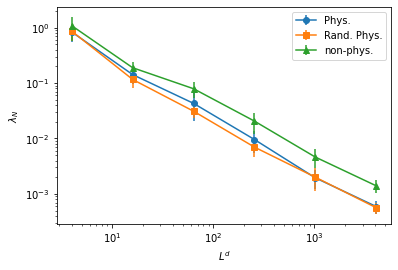

In [18]:
key = (2,'LERW')
plt.errorbar(lambda2['LD'][key],lambda2['phys'][key],yerr=lambda2['phys_std'][key],fmt='o-',label='Phys.')
plt.errorbar(lambda2['LD'][key],lambda2['rand'][key],yerr=lambda2['rand_std'][key],fmt='s-',label='Rand. Phys.')
plt.errorbar(lambda2['LD'][key],lambda2['nonphys'][key],yerr=lambda2['nonphys_std'][key],fmt='^-',label='non-phys.')
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.xlabel(r"$L^d$")
plt.ylabel(r"$\lambda_N$")

Text(0, 0.5, '$\\lambda_N$')

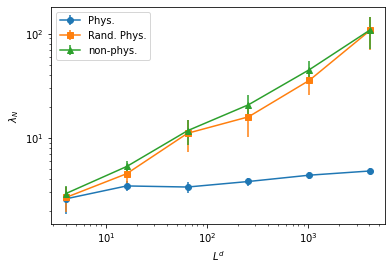

In [19]:
key = (2,'LERW')
plt.errorbar(lambdaN['LD'][key],lambdaN['phys'][key],yerr=lambdaN['phys_std'][key],fmt='o-',label='Phys.')
plt.errorbar(lambdaN['LD'][key],lambdaN['rand'][key],yerr=lambdaN['rand_std'][key],fmt='s-',label='Rand. Phys.')
plt.errorbar(lambdaN['LD'][key],lambdaN['nonphys'][key],yerr=lambdaN['nonphys_std'][key],fmt='^-',label='non-phys.')
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.xlabel(r"$L^d$")
plt.ylabel(r"$\lambda_N$")

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


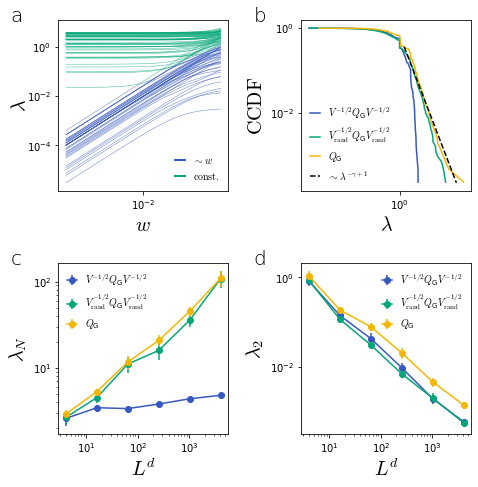

In [21]:
fig, ax = plt.subplots(2,2,figsize=(2*(3+3/8),2*(3+3/8)))

#lambda-w
plt.sca(ax[0,0])

for i in range(1,cg0.vcount()):
    plt.plot(ws,a_all_eigs[i],c=colors[0],lw=.5,alpha=.75)
for i in range(cg0.vcount(),sk0.vcount()-1):
    plt.plot(ws,a_all_eigs[i],c=colors[1],lw=.5,alpha=.75)

plt.plot([None],[None],c=colors[0],lw=2.,label=r'$\sim w$')
plt.plot([None],[None],c=colors[1],lw=2.,label=r'$\mathrm{const.}$')
plt.xscale('log')
plt.yscale('log')

plt.ylabel(r'$\lambda$',labelpad=-3)
plt.xlabel(r'$w$')
plt.legend(handlelength=1.,fontsize=10,frameon=False);


##lambda CCDF

plt.sca(ax[0,1])


ecdf = ECDF(eigs_pcg[1:],side='left')
pcg_ccdf = 1-ecdf(eigs_pcg[1:])
plt.plot(eigs_pcg[1:],pcg_ccdf,c=colors[0],label=r'$V^{-1/2}Q_\mathcal{G}V^{-1/2}$')

ecdf = ECDF(eigs_rpcg[1:],side='left')
rpcg_ccdf = 1-ecdf(eigs_rpcg[1:])
plt.plot(eigs_rpcg[1:],rpcg_ccdf,c=colors[1],label=r'$V_\mathrm{rand}^{-1/2}Q_\mathcal{G}V_\mathrm{rand}^{-1/2}$')

ecdf = ECDF(eigs_cg[1:],side='left')
cg_ccdf = 1-ecdf(eigs_cg[1:])
plt.plot(eigs_cg[1:],cg_ccdf,c=colors[2],label=r'$Q_\mathcal{G}$')


zetas = [5/4, 1.6183, 2, 2]
x=np.logspace(np.log10(1.5),np.log10(150.),10,base=10)
plt.plot(x,.7*x**(-2/zetas[0]),'k--',label=r'$\sim \lambda^{-\gamma+1}$')#,linewidth=.8)

plt.xscale('log')
plt.yscale('log')

plt.ylabel(r'$\mathrm{CCDF}$')
plt.xlabel(r'$\lambda$')

plt.legend(handlelength=1.,fontsize=10,frameon=False);


##lambdaN-Ld

plt.sca(ax[1,0])

key = (2,'LERW')
plt.errorbar(lambdaN['LD'][key],lambdaN['phys'][key],
             yerr=np.array(lambdaN['phys_std'][key])*1.96/np.sqrt(indep),
             fmt='o-',c=colors[0],label=r'$V^{-1/2}Q_\mathcal{G}V^{-1/2}$')
plt.errorbar(lambdaN['LD'][key],lambdaN['rand'][key],
             yerr=np.array(lambdaN['rand_std'][key])*1.96/np.sqrt(indep),
             fmt='o-',c=colors[1],label=r'$V_\mathrm{rand}^{-1/2}Q_\mathcal{G}V_\mathrm{rand}^{-1/2}$')
plt.errorbar(lambdaN['LD'][key],lambdaN['nonphys'][key],
             yerr=np.array(lambdaN['nonphys_std'][key])*1.96/np.sqrt(indep),
             fmt='o-',c=colors[2],label=r'$Q_\mathcal{G}$')
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.xlabel(r"$L^d$")
plt.ylabel(r"$\lambda_N$")

plt.legend(handlelength=1.,fontsize=10,frameon=False);


##lambda2-N

plt.sca(ax[1,1])
key = (2,'LERW')
plt.errorbar(lambda2['LD'][key],lambda2['phys'][key],
             yerr=np.array(lambda2['phys_std'][key])*1.96/np.sqrt(indep),
             fmt='o-',c=colors[0],label=r'$V^{-1/2}Q_\mathcal{G}V^{-1/2}$')
plt.errorbar(lambda2['LD'][key],lambda2['rand'][key],
             yerr=np.array(lambda2['rand_std'][key])*1.96/np.sqrt(indep),
             fmt='o-',c=colors[1],label=r'$V_\mathrm{rand}^{-1/2}Q_\mathcal{G}V_\mathrm{rand}^{-1/2}$')
plt.errorbar(lambda2['LD'][key],lambda2['nonphys'][key],
             yerr=np.array(lambda2['nonphys_std'][key])*1.96/np.sqrt(indep),
             fmt='o-',c=colors[2],label=r'$Q_\mathcal{G}$')


plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.xlabel(r"$L^d$")
plt.ylabel(r"$\lambda_2$")

plt.legend(handlelength=1.,fontsize=10,frameon=False);

#===========================


plt.text(-0.28, 1.08,'a', ha='left', va='top', transform = ax[0,0].transAxes,weight='light')
plt.text(-0.28, 1.08,'b', ha='left', va='top', transform = ax[0,1].transAxes,weight='light')
plt.text(-0.28, 1.08,'c', ha='left', va='top', transform = ax[1,0].transAxes,weight='light')
plt.text(-0.28, 1.08,'d', ha='left', va='top', transform = ax[1,1].transAxes,weight='light')

lm =.1
bm =.1
rm =.05+lm
tm =.05+bm


ax[0,0].set_position((0.0+lm,0.5+bm,.5-rm,.5-tm))
ax[0,1].set_position((0.5+lm,0.5+bm,.5-rm,.5-tm))
ax[1,0].set_position((0.0+lm,0.+bm, .5-rm,.5-tm))
ax[1,1].set_position((0.5+lm,0.+bm ,.5-rm,.5-tm))

for a in ax.reshape(-1):
    plt.sca(a)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    

    
plt.savefig('out.pdf')